[*********************100%%**********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 447      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.52    |
|    explained_variance | -0.357   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.23     |
|    value_loss         | 34.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 415      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.126   |
|    explained_variance | 0.073    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.113    |
|    value_loss      

0.5581395348837209

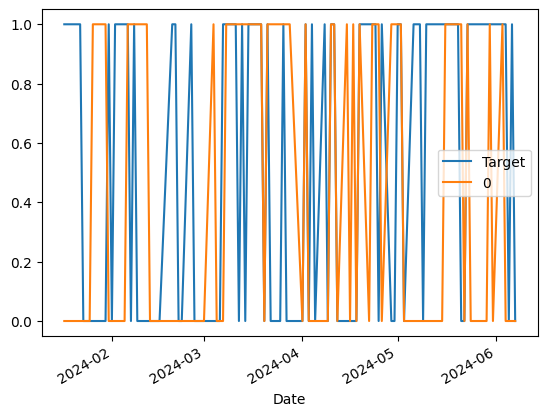

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score


# Fetch historical stock data using Yahoo Finance
def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['Tomorrow'] = stock_data['Close'].shift(-1)
    stock_data['Target'] = (stock_data['Tomorrow'] > stock_data['Close']).astype(int)
    return stock_data

# Preprocess the data and prepare it for the RL environment
def preprocess_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Define the RL environment for stock trading
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.current_step = 0
        self.max_steps = len(data)
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(len(data[0]),), dtype=np.float32)
    
    def reset(self):
        self.balance = self.initial_balance
        self.current_step = 0
        self.actions_memory = []
        return self.data[self.current_step]
    def step(self, action):
        if self.current_step >= self.max_steps - 1:
            # If we have reached the end of the data, return zeros and mark the episode as done
            return np.zeros_like(self.data[0]), 0, True, {}

        # Get the current price and the action taken
        current_price = self.data[self.current_step, 0]  # Assuming price is the first column
        action_type = action  # Assuming action is represented as integers (0 for Buy, 1 for Sell, 2 for Hold)

        # Calculate the reward based on the action taken
        if action_type == 0:  # Buy
            reward = -current_price  # Buying at the current price
            self.balance -= current_price
        elif action_type == 1:  # Sell
            reward = current_price  # Selling at the current price
            self.balance += current_price
        else:  # Hold
            reward = 0  # No immediate reward for holding

        # Move to the next time step
        self.current_step += 1

        # Check if the episode is done (whether we have reached the end of the data)
        done = self.current_step >= self.max_steps - 1

        # Get the next observation (state)
        next_observation = self.data[self.current_step]

        # Additional information (optional)
        info = {}  # Additional information, if needed

        return next_observation, reward, done, info

# Define and train the DRL model
def train_rl_model(data):
    env = DummyVecEnv([lambda: StockTradingEnv(data)])
    model = A2C('MlpPolicy', env, verbose=1)
    model.learn(total_timesteps=10000)  # Adjust as needed
    return model

# Fetch and preprocess data
stock_data = fetch_stock_data('AAPL', '2020-01-01', '2024-06-09')
processed_data, scaler = preprocess_data(stock_data)

# Train the RL model
rl_model = train_rl_model(processed_data)

# Make predictions using the trained model
def make_predictions(model, data):
    env = DummyVecEnv([lambda: StockTradingEnv(data)])
    obs = env.reset()
    predictions = []
    for _ in range(len(data)):
        action, _ = model.predict(obs)
        obs, _, _, _ = env.step(action)
        predictions.append(action)
    return predictions

predictions = make_predictions(rl_model, processed_data)

# Your existing code with RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train_rf = stock_data.iloc[:-100]
test_rf = stock_data.iloc[-100:]

predictors_rf = ['Close', 'Volume', 'Open', 'High', 'Low']

model_rf.fit(train_rf[predictors_rf], train_rf['Target'])

# Make predictions using RandomForestClassifier
pred_rf = model_rf.predict(test_rf[predictors_rf])
pred_rf = pd.Series(pred_rf, index=test_rf.index)

precision_rf = precision_score(test_rf['Target'], pred_rf)

combined_rf = pd.concat([test_rf['Target'], pred_rf], axis=1)
combined_rf.plot()
precision_rf
